In [43]:
#import necessary libraries
import csv
import pandas as pd
import numpy as np
#import pandas_profiling as pp
#from pandas_profiling import ProfileReport
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot


from sklearn.metrics import confusion_matrix

In [44]:
#read the cleaned dataset for London
df = pd.read_csv('London_traffic_accidents.csv')    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106938 entries, 0 to 106937
Data columns (total 89 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   index                                        106938 non-null  int64  
 1   geometry                                     106938 non-null  object 
 2   index_right                                  106938 non-null  int64  
 3   NAME                                         106938 non-null  object 
 4   GSS_CODE                                     106938 non-null  object 
 5   HECTARES                                     106938 non-null  float64
 6   NONLD_AREA                                   106938 non-null  float64
 7   LB_GSS_CD                                    106938 non-null  object 
 8   BOROUGH                                      106938 non-null  object 
 9   POLY_ID                                      106938 non-nul

In [45]:
#copy a new dataframe for further model testing
df1=df.copy()

In [46]:
# Dropping unnecessary columns
df1.drop(['accident_index', 'longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', 
                'date', 'special_conditions_at_site', 
                'lsoa_of_accident_location','converted_time'], 
               axis=1, inplace=True)

In [47]:
df1.dropna()

,index,geometry,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,0,POINT (-0.279323 51.584754),182,Kenton,E05000093,224.315,0.0,E09000005,Brent,116946,...,Journey as part of work,1.0,51.0,8.0,1461.0,Petrol,8.0,-1,3.0,1.0
1,1063,POINT (-0.314008 51.583639),182,Kenton,E05000093,224.315,0.0,E09000005,Brent,116946,...,Not known,1.0,67.0,10.0,2143.0,Heavy Oil,3.0,-1,7.0,1.0
2,1120,POINT (-0.282202 51.584976),182,Kenton,E05000093,224.315,0.0,E09000005,Brent,116946,...,Not known,1.0,31.0,6.0,1339.0,Hybrid electric,6.0,-1,4.0,1.0
3,1202,POINT (-0.306828 51.586503),182,Kenton,E05000093,224.315,0.0,E09000005,Brent,116946,...,Not known,1.0,20.0,4.0,2499.0,Heavy Oil,8.0,-1,4.0,1.0
4,3411,POINT (-0.307563 51.586154),182,Kenton,E05000093,224.315,0.0,E09000005,Brent,116946,...,Not known,1.0,41.0,7.0,1248.0,Heavy Oil,4.0,-1,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106933,243695,POINT (-0.091137 51.518141),627,Cripplegate,E05000015,14.545,0.0,E09000001,City of London,122522,...,Other,1.0,58.0,9.0,1797.0,Hybrid electric,8.0,-1,-1.0,-1.0
106934,243719,POINT (-0.09736300000000001 51.521614),627,Cripplegate,E05000015,14.545,0.0,E09000001,City of London,122522,...,Other,2.0,36.0,7.0,782.0,Petrol,8.0,-1,-1.0,-1.0
106935,243743,POINT (-0.090361 51.519477),627,Cripplegate,E05000015,14.545,0.0,E09000001,City of London,122522,...,Journey as part of work,1.0,59.0,9.0,2148.0,Heavy Oil,8.0,-1,-1.0,-1.0
106936,365105,POINT (-0.09370199999999999 51.517481),627,Cripplegate,E05000015,14.545,0.0,E09000001,City of London,122522,...,Journey as part of work,2.0,25.0,5.0,108.0,Petrol,8.0,-1,2.0,1.0


In [48]:
df2 =df1.apply(lambda x : x.astype('category')) 

In [49]:
df2 =df2.apply(lambda x: x.cat.codes)  

In [50]:
#define x and y for training and testing
#y is the accident severity
dataset_y = df2[ 'accident_severity']
dataset_x = df2.drop([ 'accident_severity' ], axis= 1 )
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size= 0.30 , random_state= 42 )

## Calculating the feature importances

In [51]:
#calculating the feature importances using random forest classifier method
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

importances = model.feature_importances_
dst_X = X_train
data = dst_X.columns
t = pd.DataFrame(data, columns = ['Features'])
t['Importances'] = importances
rank_attr = t.sort_values(by=['Importances'], ascending=False)
print(rank_attr)
top50 = rank_attr[0:50]['Features']

                  Features  Importances
44       casualty_severity     0.618361
0                    index     0.016139
11      accident_reference     0.015516
13  location_northing_osgr     0.014367
12   location_easting_osgr     0.013952
..                     ...          ...
48  bus_or_coach_passenger     0.000332
35         trunk_road_flag     0.000214
39      casualty_reference     0.000089
14            police_force     0.000070
55     vehicle_reference_y     0.000000

[79 rows x 2 columns]


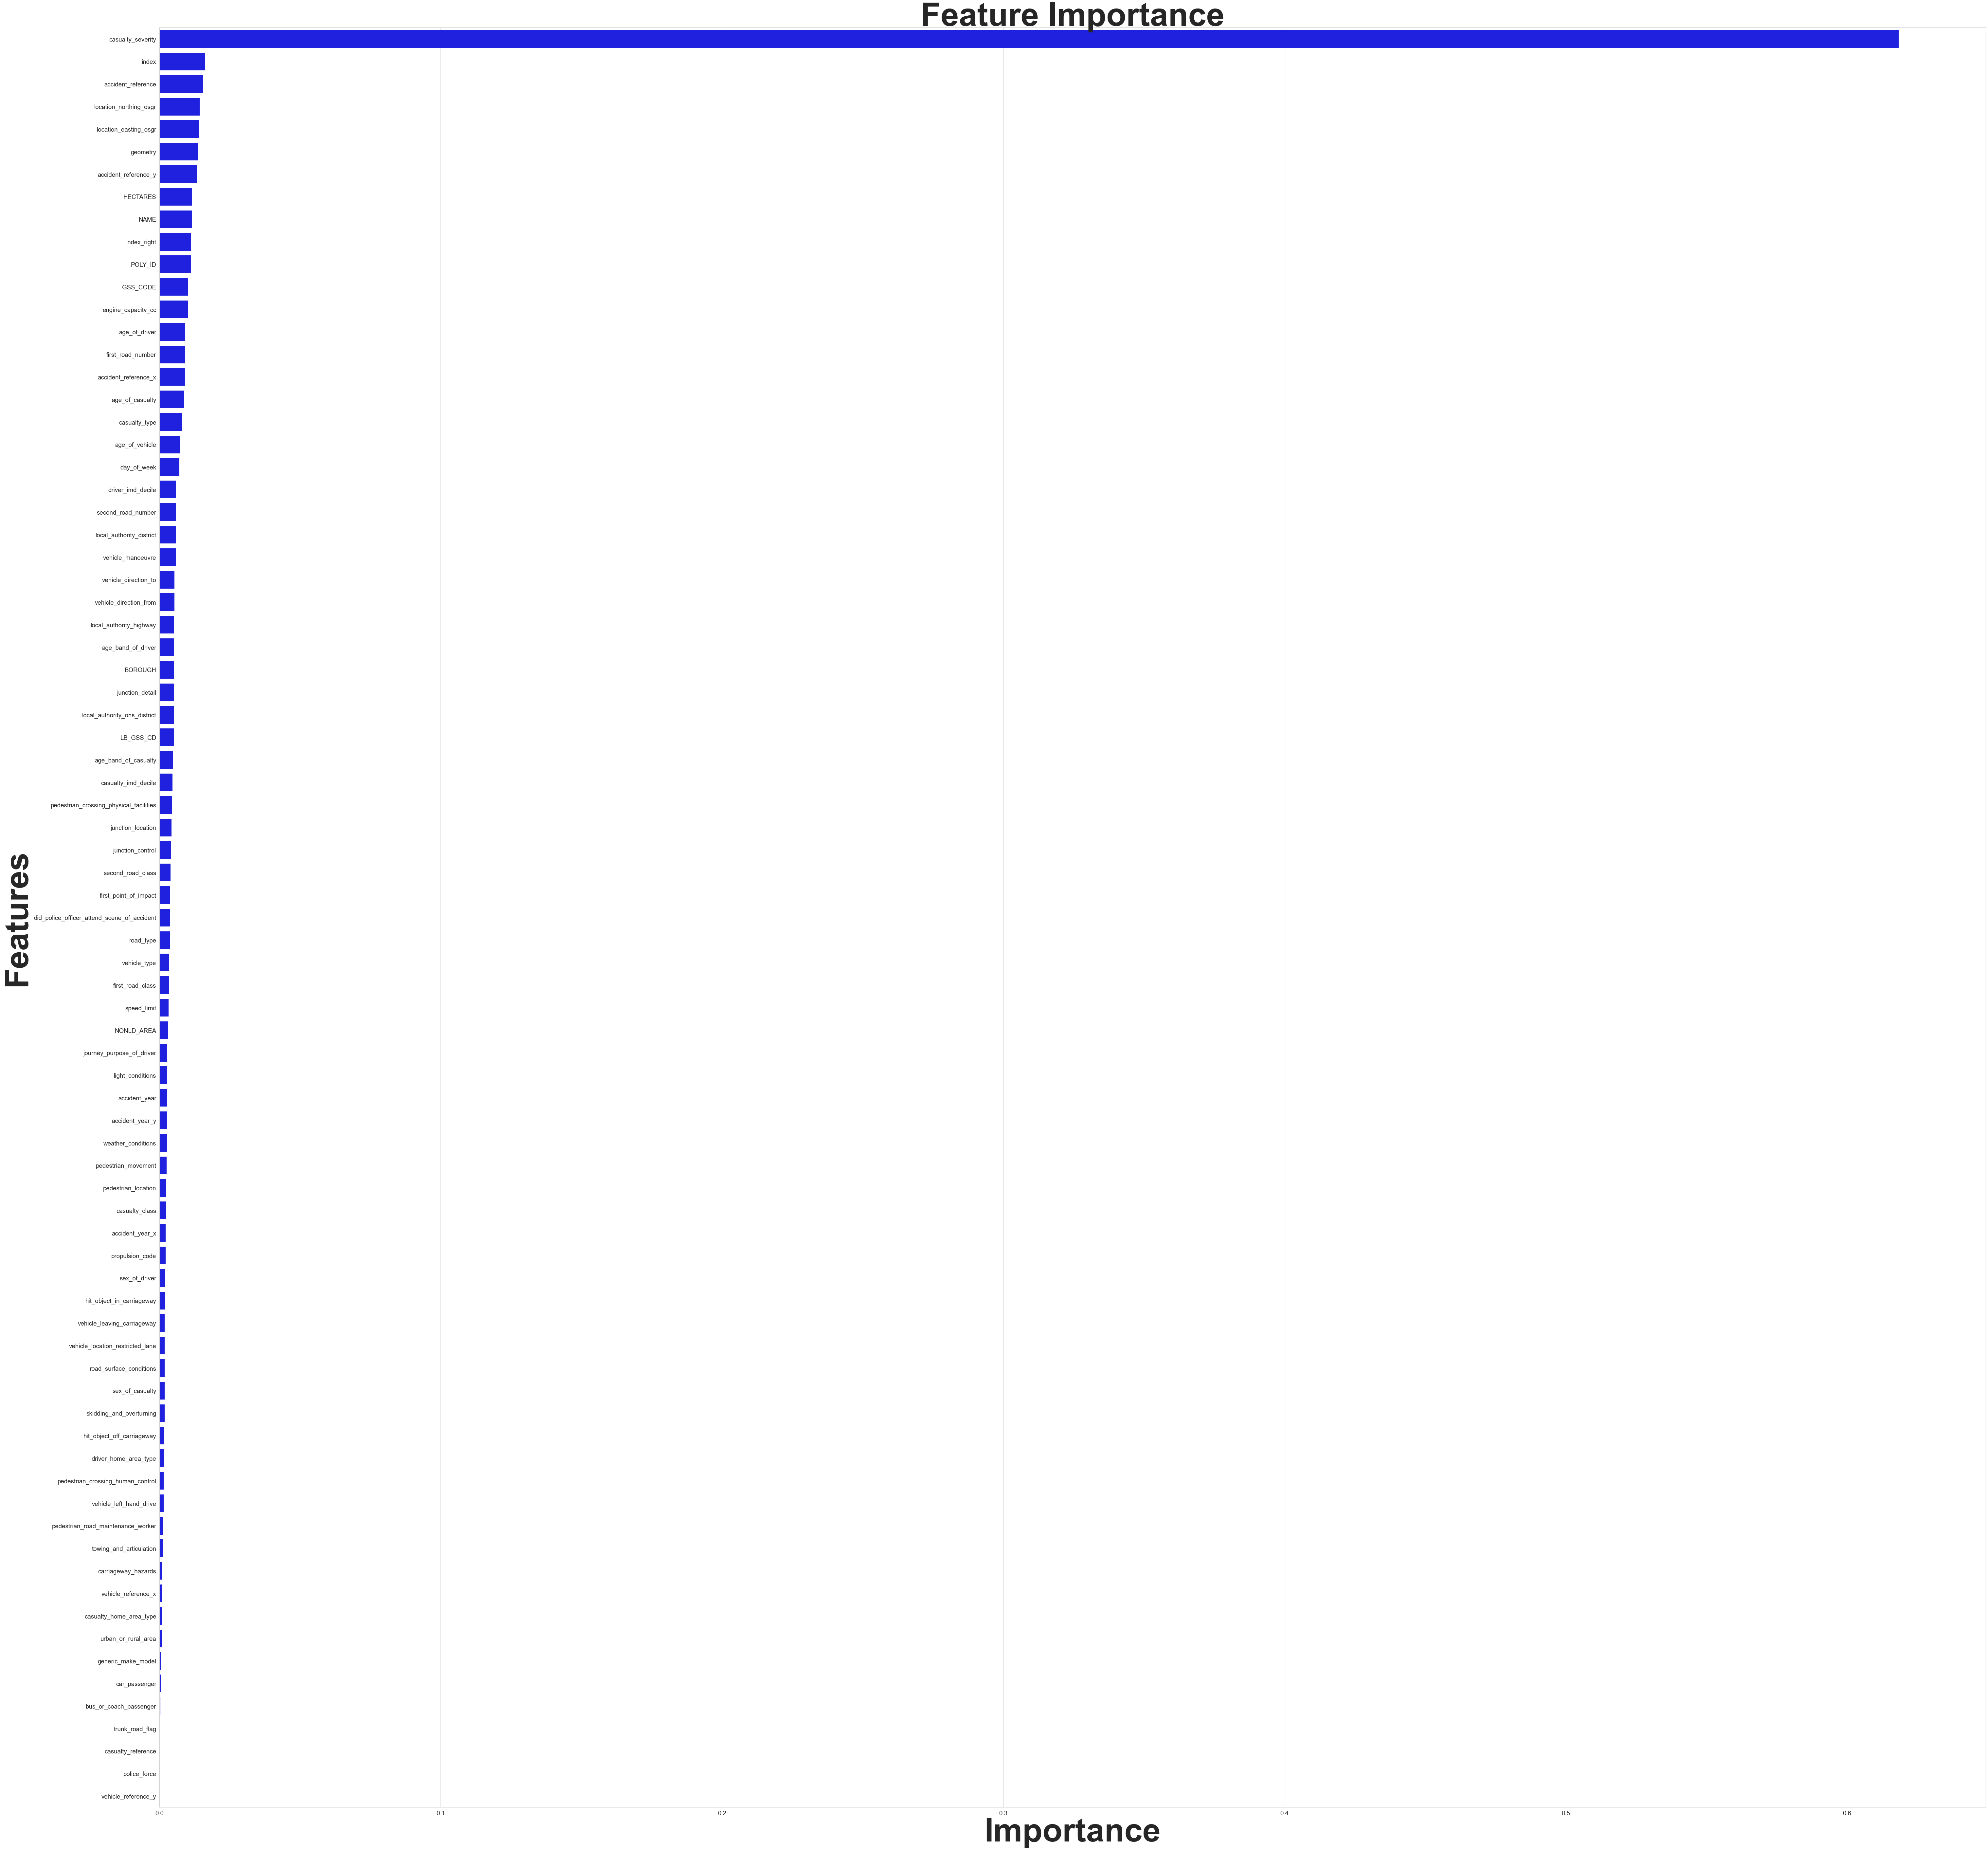

None

In [52]:
feats = {}
for feature, importance in zip(dst_X.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 25)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(100,100)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='blue')
plt.xlabel('Importance', fontsize=100, weight = 'bold')
plt.ylabel('Features', fontsize=100, weight = 'bold')
plt.title('Feature Importance', fontsize= 100, weight = 'bold')
display(plt.show())

In [53]:
#check the top 50 important features
importances.head(50)

,Features,Importance
0,casualty_severity,0.618361
1,index,0.016139
2,accident_reference,0.015516
3,location_northing_osgr,0.014367
4,location_easting_osgr,0.013952
5,geometry,0.013754
6,accident_reference_y,0.013339
7,HECTARES,0.011674
8,NAME,0.011643
9,index_right,0.011273


In [54]:
#selecting predictors from the above features
predictors = df2[['did_police_officer_attend_scene_of_accident' , 'age_of_driver' ,'vehicle_type', 'age_of_vehicle',
                             'engine_capacity_cc','day_of_week' , 'road_type', 'weather_conditions', 'journey_purpose_of_driver',
                             'sex_of_driver' ,'speed_limit','pedestrian_crossing_physical_facilities','junction_control','light_conditions']]

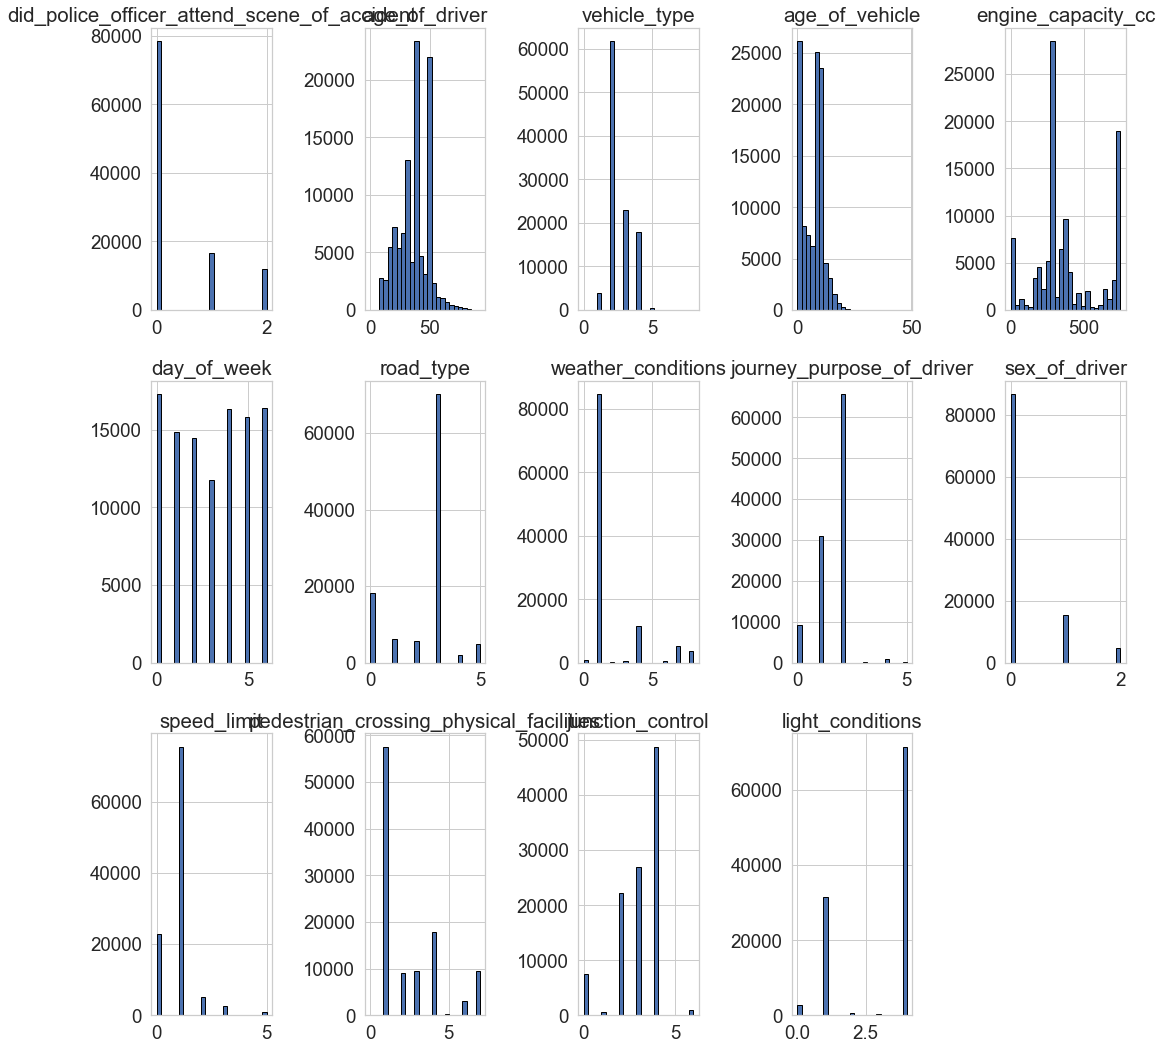

In [55]:
#view the distribution of the variables
predictors.hist(bins=25, figsize=(15, 15), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [56]:
#selecting X and y parameters
X= predictors
y=df2['accident_severity']

In [57]:
# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(predictors.values, 
                                              df2['accident_severity'].values,test_size=0.30, random_state=99)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(74856, 14)
(32082, 14)
(74856,)
(32082,)


In [59]:
#imbalanced dataset
df2['accident_severity'].value_counts()

2    92497
1    13950
0      491
Name: accident_severity, dtype: int64

# Imbalanced Dataset

## Random Forest

In [60]:
#define the random forest model
random_forest = RandomForestClassifier(n_estimators=200)
#fit the model on the train data
random_forest.fit(X_train,y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)
acc_random_forest1 = round(random_forest.score(X_test, y_test) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=Y_pred)
print("Accuracy" , acc_random_forest1)
print(sk_report)
#confusion matrix
pd.crosstab(y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 85.74
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000       173
           1   0.163324  0.013685  0.025255      4165
           2   0.865171  0.989439  0.923142     27744

    accuracy                       0.857428     32082
   macro avg   0.342831  0.334375  0.316132     32082
weighted avg   0.769389  0.857428  0.801597     32082



Predicted,0,1,2,All
Actual,,,,
0,0,3,170,173
1,0,57,4108,4165
2,4,289,27451,27744
All,4,349,31729,32082


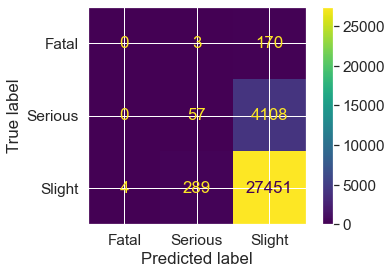

In [61]:
from sklearn.metrics import plot_confusion_matrix
#plot confusion matrix
sns.set(font_scale=1.4)
class_sentiment =['Fatal', 'Serious','Slight']
plot_confusion_matrix(random_forest,X_test,y_test, normalize =None, values_format='.0f',display_labels =class_sentiment)

## Logistic Regression

In [64]:
#define the logistic regression model
lr = LogisticRegression()
# Fit the model on the training data.
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred)
print("Accuracy", round(accuracy_score(y_pred, y_test)*100,2))
print(sk_report)

Accuracy 86.48
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000       173
           1   0.000000  0.000000  0.000000      4165
           2   0.864784  1.000000  0.927490     27744

    accuracy                       0.864784     32082
   macro avg   0.288261  0.333333  0.309163     32082
weighted avg   0.747851  0.864784  0.802078     32082



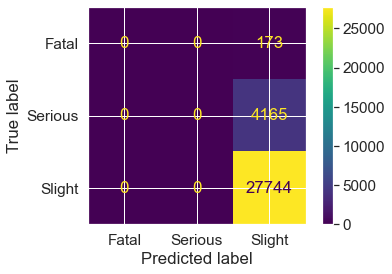

In [65]:
#plot confusion matrix
sns.set(font_scale=1.4)
class_sentiment =['Fatal', 'Serious','Slight']
plot_confusion_matrix(lr,X_test,y_test, normalize =None, values_format='.0f',display_labels =class_sentiment)

## K Nearnest Neigbors

In [66]:
KNeighbors_classifier = KNeighborsClassifier()                       
KNeighbors=KNeighbors_classifier.fit(X_train,y_train)                               
kn_preds = KNeighbors.predict(X_test)

test_report_kn = classification_report(y_test, kn_preds)
# print the performace measures
print(test_report_kn)
print("Accuracy of KNeighbors Classifier:", metrics.accuracy_score(y_test, kn_preds))

              precision    recall  f1-score   support

           0       0.12      0.01      0.01       173
           1       0.17      0.03      0.05      4165
           2       0.87      0.98      0.92     27744

    accuracy                           0.85     32082
   macro avg       0.39      0.34      0.33     32082
weighted avg       0.77      0.85      0.80     32082

Accuracy of KNeighbors Classifier: 0.849479458886603


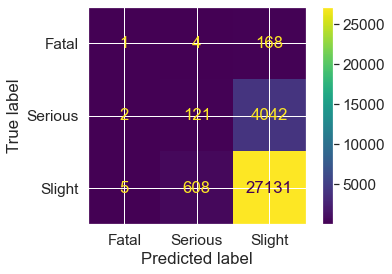

In [67]:
#plot confusion matrix
sns.set(font_scale=1.4)
class_sentiment =['Fatal', 'Serious','Slight']
plot_confusion_matrix(KNeighbors_classifier,X_test,y_test, normalize =None, values_format='.0f',display_labels =class_sentiment)

# SMOTE Oversampling Techniques

In [68]:
sm = SMOTE()

#X=np.array(X)

X, y = sm.fit_resample(X, y.ravel())

In [69]:
# Oversampling
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)
## train test split
X_train_over,X_test_over,y_train_over,y_test_over = train_test_split(X,y,test_size=0.3,random_state=42)
#setting 20% aside as validation data for cross validation
x_train_t, x_train_v, y_train_t, y_train_v = train_test_split(X_train_over, y_train_over, test_size = 0.3, random_state = 42)

In [70]:
#check the oversampled result
pd.Series(y).value_counts()

2    92497
1    92497
0    92497
dtype: int64

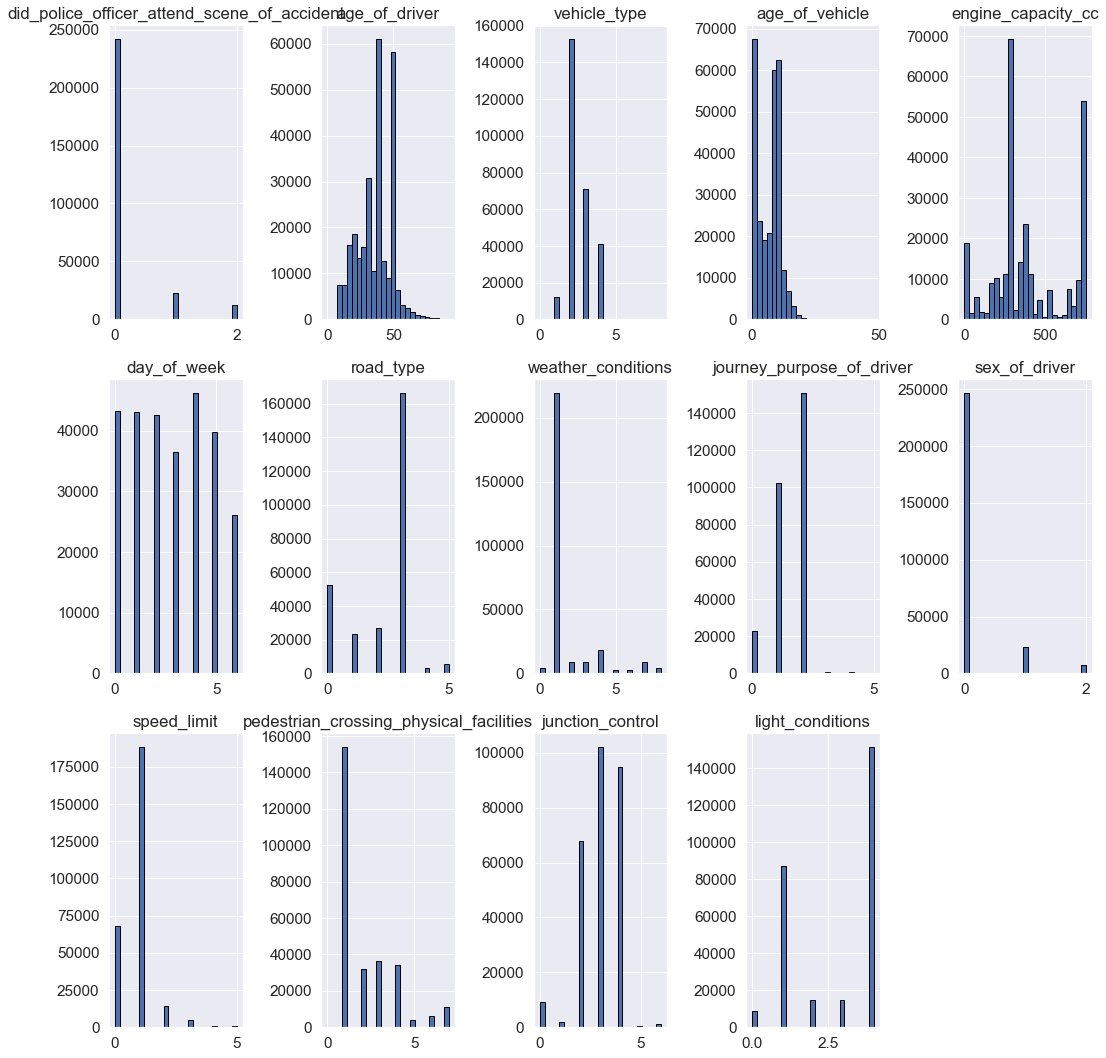

In [71]:
#view the distribution of the variables
X.hist(bins=25, figsize=(15, 15), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

## Random Forest after SMOTE

In [72]:
#define the model
random_forest = RandomForestClassifier(n_estimators=200)
#fit the model
random_forest.fit(X_train_over,y_train_over)
Y_pred = random_forest.predict(X_test_over)
random_forest.score(X_test_over, y_test_over)
acc_random_forest1 = round(random_forest.score(X_test_over, y_test_over) * 100, 2)

sk_report = classification_report(
    digits=6,
    y_true=y_test_over, 
    y_pred=Y_pred)
print("Accuracy" , acc_random_forest1)
print(sk_report)
pd.crosstab(y_test_over, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 83.18
              precision    recall  f1-score   support

           0   0.895519  0.971946  0.932169     27946
           1   0.762944  0.796220  0.779227     27834
           2   0.834681  0.725317  0.776165     27468

    accuracy                       0.831816     83248
   macro avg   0.831048  0.831161  0.829187     83248
weighted avg   0.831119  0.831816  0.829559     83248



Predicted,0,1,2,All
Actual,,,,
0,27162,668,116,27946
1,1842,22162,3830,27834
2,1327,6218,19923,27468
All,30331,29048,23869,83248


No handles with labels found to put in legend.


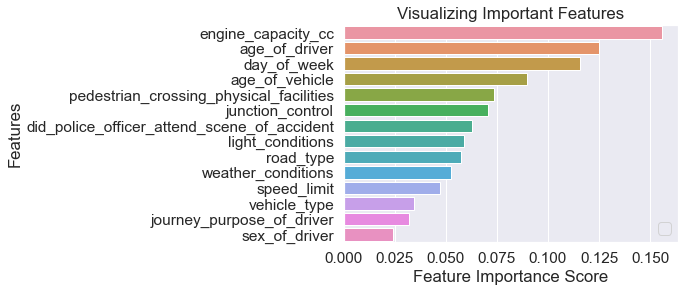

In [73]:
feature_imp = pd.Series(random_forest.feature_importances_,index=predictors.columns).sort_values(ascending=False)
# Creating a bar plot, displaying only the top k features
k=15
sns.barplot(x=feature_imp[:15], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Logistic Regression after SMOTE

In [75]:
#define the model
lr = LogisticRegression()
# Fit the model on the training data.
lr.fit(X_train_over, y_train_over)
y_pred = lr.predict(X_test_over)
sk_report = classification_report(
    digits=6,
    y_true=y_test_over, 
    y_pred=y_pred)
print("Accuracy", round(accuracy_score(y_pred, y_test_over)*100,2))
print(sk_report)
pd.crosstab(y_test_over, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Accuracy 45.73
              precision    recall  f1-score   support

           0   0.472271  0.524440  0.496990     27946
           1   0.397993  0.383308  0.390513     27834
           2   0.501692  0.464067  0.482147     27468

    accuracy                       0.457332     83248
   macro avg   0.457319  0.457272  0.456550     83248
weighted avg   0.457144  0.457332  0.456492     83248



Predicted,0,1,2,All
Actual,,,,
0,14656,8332,4958,27946
1,9462,10669,7703,27834
2,6915,7806,12747,27468
All,31033,26807,25408,83248


## KNN after SMOTE

In [76]:
KNeighbors_classifier = KNeighborsClassifier()   
KNeighbors=KNeighbors_classifier.fit(X_train_over,y_train_over)                     
kn_preds = KNeighbors.predict(X_test_over)
test_report_kn = classification_report(y_test_over, kn_preds)
# print the performace measures
print(test_report_kn)

print("Accuracy of KNeighbors Classifier:", metrics.accuracy_score(y_test_over, kn_preds))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     27946
           1       0.68      0.83      0.75     27834
           2       0.83      0.53      0.65     27468

    accuracy                           0.78     83248
   macro avg       0.79      0.77      0.77     83248
weighted avg       0.79      0.78      0.77     83248

Accuracy of KNeighbors Classifier: 0.7755862002690755
